# Contruct Book Networks

In [86]:
import pickle
import numpy as np
from igraph import *
import sqlite3 as lite
from collections import Counter
from scipy.stats import pearsonr
%matplotlib inline
import pylab as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ks_2samp

### Amazon books

#### Connect to database

In [2]:
amazon_db = lite.connect("../AmazonBooks/amazon.db")
amazon_db.text_factory = str
cur=amazon_db.cursor()

#### Index books

In [3]:
cur.execute("select id, isbn, c1,c2,c3,c4,c5,c6,c7,c8,c9,c10 from unique_book_attribute")
book_entries = cur.fetchall()
isbn2id=dict()
id2isbn=dict()
count=0  # in igraph index of vertices starts from 0!
for item in book_entries:
    isbn2id[item[1]] = count
    id2isbn[count] = item[1]
    count+=1

#with open('../AmazonBooks/isbn2id.pkl','wb') as outfile:
#    pickle.dump(isbn2id,outfile)

#with open('../AmazonBooks/id2isbn.pkl','wb') as outfile:
#    pickle.dump(id2isbn,outfile)

#### Index topics

In [4]:
topics = set()
for entry in book_entries:
    topics.update(entry[2:12])

topics.discard('');
topics.discard(None);
topics=list(topics)
topics.sort()
id2topic = dict() 
topic2id = dict() 
count=0
for t in topics:
    id2topic[count] = t
    topic2id[t] = count
    count+=1

#with open('../AmazonBooks/id2topic.pkl','wb') as outfile:
#    pickle.dump(id2topic,outfile)

#with open('../AmazonBooks/topic2id.pkl','wb') as outfile:
#    pickle.dump(topic2id,outfile)

#### Create edge list of books

In [ ]:
cur.execute("select book1, book2 from cop_list")
items = cur.fetchall()    
outfile = open('../AmazonBooks/edgelist_books.txt','w') 
count=0
with outfile:
    for item in items:
        count+=1
        if count%100000==0:
            print count
        nd1 = isbn2id[item[0]] 	
        nd2 = isbn2id[item[1]] 
        outfile.write(str(nd1)+" "+str(nd2)+"\n")

#### Create copurchase network

In [5]:
g = Graph.Read_Edgelist("../AmazonBooks/edgelist_books.txt",directed=False)
g.simplify();

#### Annotate nodes attributes

In [7]:
for item in book_entries:
    topics = set()
    for t in item[2:12]:
        if t in topic2id:
            topics.add(topic2id[t])
    g.vs[isbn2id[item[1]]]['topics'] = list(topics)

cur.execute("select isbn, title, rank, publisher, price from unique_book_attribute")
book_entries = cur.fetchall()
isbn,title,rank, publisher, price=zip(*book_entries)
g.vs['isbn']=isbn
g.vs['title']=title
g.vs['rank']=rank
sales=np.array(rank,dtype=float)
sales[sales>0]=np.exp(8.046-0.613*np.log(sales[sales>0]))
g.vs['sales']=sales
g.vs['publisher']=publisher
g.vs['price']=price

In [ ]:
with open('../AmazonBooks/isbn_network.pkl','wb') as outfile:
    pickle.dump(g,outfile)

In [ ]:
cur.execute("select isbn, publisher, price from unique_book_attribute")
book_entries = cur.fetchall()

In [ ]:
isbn2pub={}
for entry in book_entries:
    isbn2pub[entry[0]]=entry[1].split('(')[0].split(';')[0].strip()
with open("../AmazonBooks/isbn2publisher.pkl","wb") as outfile:
    pickle.dump(isbn2pub,outfile)

In [ ]:
isbn2price={}
for entry in book_entries:
    isbn2price[entry[0]]=entry[2]
with open("../AmazonBooks/isbn2price.pkl","wb") as outfile:
    pickle.dump(isbn2price,outfile)

### Statistics

In [8]:
g.summary()

'IGRAPH U--- 1449525 28585786 -- \n+ attr: isbn (v), price (v), publisher (v), rank (v), sales (v), title (v), topics (v)'

#### Sales v.s. recommendation

In [8]:
cur.execute("select book1, book2 from cop_list")
items = cur.fetchall()  
adjlist={}
for i in items:
    if i[0] not in adjlist:
        adjlist[i[0]]=[]
    adjlist[i[0]].append(isbn2id[i[1]])

In [50]:
corr=map(lambda x: [x[0]]+list(pearsonr(xrange(len(x[1])),[g.vs[i]['rank'] for i in x[1]])), adjlist.iteritems())
corr=pd.DataFrame(corr)
corr=corr.dropna()
corr['degree']=g.vs[map(lambda x: isbn2id[x], corr[0])].degree()

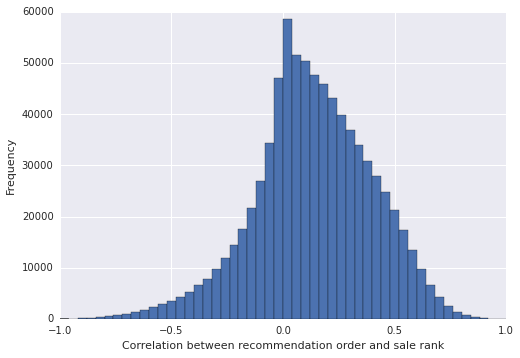

In [56]:
plt.hist(corr[corr['degree']>10][1],50);
plt.xlabel('Correlation between recommendation order and sale rank')
plt.ylabel('Frequency')

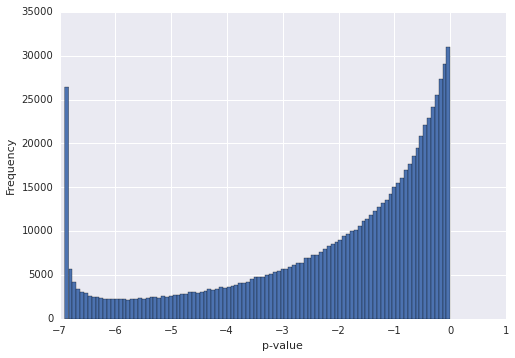

In [74]:
plt.hist(np.log(corr[corr['degree']>10][2]+0.001),100);
plt.xlabel('p-value')
plt.ylabel('Frequency')

In [45]:
Counter(g.vs[map(lambda x: isbn2id[x], corr[corr[1]==-1][0])].degree())

Counter({2: 26381, 3: 2732, 4: 436, 5: 112, 6: 38, 7: 19, 8: 4, 9: 3, 44: 1, 13: 1, 108: 1, 23: 1, 24: 1, 28: 1})

#### Sales of blue and red books

In [139]:
cur.execute("select isbn, rank from unique_book_attribute")
book_entries = cur.fetchall()
pubrank=dict(book_entries)

In [146]:
liberals={}
with open('../BookCodes/liberals1008.txt') as l:
    for line in l:
        if line.strip() in pubrank:
            if int(pubrank[line.strip()])>0:
                rank=int(pubrank[line.strip()])#np.exp(8.046-0.613*np.log(int(pubrank[line.strip()])))#
            else:
                rank=0
            liberals[line.strip()]=rank
        else:
            print '{} not in database'.format(line)

conservatives={}
with open('../BookCodes/conservatives1008.txt') as c:
    for line in c:
        if line.strip() in pubrank:
            if int(pubrank[line.strip()])>0:
                rank=int(pubrank[line.strip()])#np.exp(8.046-0.613*np.log(int(pubrank[line.strip()])))#
            else:
                rank=0
            conservatives[line.strip()]=rank
        else:
            print '{} not in database'.format(line)

In [147]:
np.mean(liberals.values()),np.mean(conservatives.values())

(1126532.1777434312, 857419.6927939317)

In [148]:
np.median(liberals.values()),np.median(conservatives.values())

(928030.0, 670603.0)

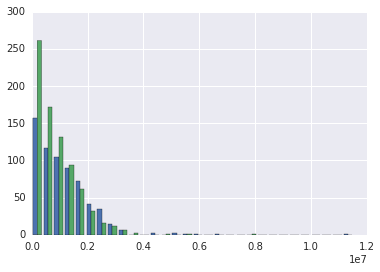

In [150]:
plt.hist([liberals.values(),conservatives.values()],30,log=False);

In [184]:
x=np.array(liberals.values())
y=np.array(conservatives.values())
x=x[x!=0]
y=y[y!=0]
x=x[x<1000000]
y=y[y<1000000]

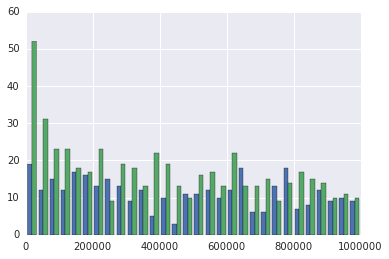

In [185]:
plt.hist([x,y],30,log=False);

In [186]:
ks_2samp(x,y)

(0.086126605885954721, 0.088442610125037152)

#### Publication year

In [123]:
cur.execute("select isbn, publisher from unique_book_attribute")
book_entries = cur.fetchall()
pubYear=dict(book_entries)

In [11]:
import re

In [124]:
prog = re.compile(r'\d{4}')

In [125]:
liberals={}
with open('../BookCodes/liberals1008.txt') as l:
    for line in l:
        if line.strip() in pubYear:
            try:
                year=int(prog.search(pubYear[line.strip()]).group())
            except:
                year=0
            liberals[line.strip()]=year
        else:
            print '{} not in database'.format(line)

conservatives={}
with open('../BookCodes/conservatives1008.txt') as c:
    for line in c:
        if line.strip() in pubYear:
            try:
                year=int(prog.search(pubYear[line.strip()]).group())
            except:
                year=0
            conservatives[line.strip()]=year
        else:
            print '{} not in database'.format(line)

In [126]:
freq=Counter(liberals.values())
freq2=Counter(conservatives.values())
del freq[0]
del freq2[0]

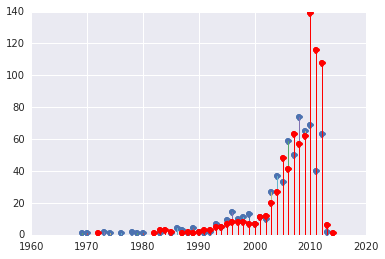

In [127]:
markerline, stemlines, baseline=plt.stem(freq.keys(),np.array(freq.values()), linefmt='-', markerfmt='o')
plt.setp(baseline,linewidth=0)
plt.setp(stemlines,linewidth=1)
markerline, stemlines, baseline=plt.stem(freq2.keys(),np.array(freq2.values()),linefmt='r-', markerfmt='ro')
plt.setp(baseline,linewidth=0);
plt.setp(stemlines,linewidth=1);

In [128]:
np.median(liberals.values()),np.median(conservatives.values())

(2007.0, 2009.0)

In [130]:
np.mean(liberals.values()),np.mean(conservatives.values())

(1999.2194744976816, 1999.6523388116309)

In [131]:
x=np.array(liberals.values())
y=np.array(conservatives.values())
x=x[x<2010]
y=y[y<2010]

In [132]:
ks_2samp(x,y)

(0.049625124916513053, 0.63229317237531713)

In [129]:
ks_2samp(liberals.values(),conservatives.values())

(0.19882878675673199, 8.2565989265749452e-13)

In [3]:
c=cur.execute("select * from unique_book_attribute limit 6,1")

In [4]:
cur.fetchall()

[(1332509,
  'English',
  'None',
  '000016612X',
  1,
  'Spiral-bound',
  'http://www.amazon.com/Policies-Procedures-Infusion-Nursing-INS/dp/000016612X',
  -1.0,
  'Policies and Procedures for Infusion Nursing: INS: 9780000166128: Amazon.com: Books',
  ' Infusion Nurses Society; 4 edition (March 2011)',
  2409419,
  'Books>>New,Used&RentalTextbooks',
  '',
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  3.0,
  2,
  -1.0)]